In [2]:
from pennylane import numpy as np
import pennylane as qml
from matplotlib import pyplot as plt

In [48]:
'''
Here we are gonna use Amplitude damping and Phase damping noise using Pauli twirl approximation

This should be same as AD and PD
'''

'\nHere we are gonna use Amplitude damping and Phase damping noise using Pauli twirl approximation\n\nThis should be same as AD and PD\n'

In [4]:
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
Y = np.array([[0,-1j],[1j, 0]])

In [5]:
'''
T1 = single-qubit (energy) relaxation time and 
T2 = dephasing time
'''

'\nT1 = single-qubit (energy) relaxation time and \nT2 = dephasing time\n'

In [19]:
t=np.linspace(1,200,200)*10**(-9)#60*10**(-9)
T1=400*10**(-9)
T2=200*10**(-9)
steps=4

In [8]:
#P_AD=0
#P_PD=0
def P(t,T1,T2):
    
    P_AD=1-np.exp(-t/T1)
    P_PD=1-np.exp(-t*2/T2)*np.exp(t/T1)
    
    return P_AD,P_PD

In [9]:
def ED(t,T1,T2):
    P_AD,P_PD=P(t,T1,T2)
    gamma=P_AD
    Lambda=(1-P_AD)*P_PD
    
    return gamma,Lambda

In [11]:
a,b=ED(0.1,0.008,0.005)
b

3.726653172049425e-06

In [12]:
dev=qml.device("default.mixed",wires=3)

In [13]:
@qml.qnode(dev)
def density_matrix(step):
   
    if step==1:
        qml.Hadamard(wires=0)
        return qml.state()
    
    if step==2:
        qml.Hadamard(wires=0)
        qml.CNOT(wires=[0,1])
        return qml.state()
    
    if step==3:
        qml.Hadamard(wires=0)
        qml.CNOT(wires=[0,1])
        qml.CNOT(wires=[0,2])
        return qml.state()
    
    
    if step==4:
        qml.Hadamard(wires=0)
        qml.CNOT(wires=[0,1])
        qml.CNOT(wires=[0,2])
        qml.Hadamard(wires=0)
        return qml.state()

In [14]:
density_matrix(1)

tensor([[0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0.5+0.j, 0. +0.j, 0. +0.j,
         0. +0.j],
        [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
         0. +0.j],
        [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
         0. +0.j],
        [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
         0. +0.j],
        [0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0.5+0.j, 0. +0.j, 0. +0.j,
         0. +0.j],
        [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
         0. +0.j],
        [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
         0. +0.j],
        [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
         0. +0.j]], requires_grad=False)

In [16]:
X1=np.kron(X,np.kron(I,I))
Y1=np.kron(Y,np.kron(I,I))
Z1=np.kron(Z,np.kron(I,I))

X2=np.kron(I,np.kron(X,I))
Y2=np.kron(I,np.kron(Y,I))
Z2=np.kron(I,np.kron(Z,I))

X3=np.kron(I,np.kron(I,X))
Y3=np.kron(I,np.kron(I,Y))
Z3=np.kron(I,np.kron(I,Z))

I3=np.kron(I,np.kron(I,I))

In [50]:
def Decoherent_state_1( t,  T1,  T2,  steps):
    
    #rho=ρ_noise
    rho=density_matrix(steps)
    
    gamma,Lambda=ED(t,T1,T2)
    
    epsilon_AD_1=(2-gamma+2*np.sqrt(1-gamma-Lambda))/4*np.dot(I3,np.dot(rho,I3))+gamma*np.dot(X1,np.dot(rho,X1))/4+\
                 gamma*np.dot(Y1,np.dot(rho,Y1))/4+ (2-gamma-2*np.sqrt(1-gamma-Lambda))/4*np.dot(Z1,np.dot(rho,Z1))- \
                 gamma/4*np.dot(I3,np.dot(rho,Z1))-gamma/4*np.dot(Z1,np.dot(rho,I3))+(gamma/(4*1j))*np.dot(X1,np.dot(rho,Y1))-\
                 (gamma/(4*1j))*np.dot(Y1,np.dot(rho,X1))
    
    return epsilon_AD_1
    

In [51]:
ρ_noise=[]
ρ_noise=[Decoherent_state_1(time,T1,T2,1) for time in t] 
len(ρ_noise)

200

In [52]:
# Function to find the fidelity between two density matrix
def Fidelity(rho1,rho2):
    if rho1.shape!=rho2.shape:
        raise ValueError("Dimension of both matrices must be same")
    return ((np.trace(np.dot(np.transpose(np.conj(rho1)),rho2))))  # as one of them is pure (entangled) state

In [53]:
rho2=density_matrix(1)  # this is the pure density matrix 
F=[]
for rho1 in ρ_noise:
    F.append(Fidelity(rho1,rho2))
    
len(F)

200

C:\Users\Arunava\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


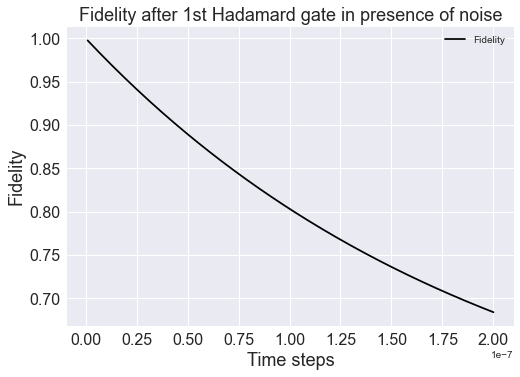

In [54]:
plt.style.use("seaborn")
plt.plot(t,F,"black",label="Fidelity")
plt.ylabel("Fidelity", fontsize=18)
plt.xlabel("Time steps", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)   # helps to increase the size of the values in X and Y axis
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.title("Fidelity after 1st Hadamard gate in presence of noise", fontsize=18)
plt.legend()
plt.show()

In [55]:
cnot=np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])

In [62]:
def Decoherent_state_2( t,  T1,  T2,  density_matrix):
    
    #rho=ρ_noise
    rho=density_matrix
    
    rho=np.dot(np.dot(np.kron(cnot,I),rho),np.kron(cnot,I)) # applying 1st CNOT to qubits=[0,1]
    
    gamma,Lambda=ED(t,T1,T2)
    
    epsilon_AD_1=(2-gamma+2*np.sqrt(1-gamma-Lambda))/4*np.dot(I3,np.dot(rho,I3))+gamma*np.dot(X1,np.dot(rho,X1))/4+\
                 gamma*np.dot(Y1,np.dot(rho,Y1))/4+ (2-gamma-2*np.sqrt(1-gamma-Lambda))/4*np.dot(Z1,np.dot(rho,Z1))- \
                 gamma/4*np.dot(I3,np.dot(rho,Z1))-gamma/4*np.dot(Z1,np.dot(rho,I3))+(gamma/(4*1j))*np.dot(X1,np.dot(rho,Y1))-\
                 (gamma/(4*1j))*np.dot(Y1,np.dot(rho,X1))
    
    epsilon_AD_2=(2-gamma+2*np.sqrt(1-gamma-Lambda))/4*np.dot(I3,np.dot(epsilon_AD_1,I3))+gamma*np.dot(X2,np.dot(epsilon_AD_1,X2))/4+\
                 gamma*np.dot(Y2,np.dot(epsilon_AD_1,Y2))/4+ (2-gamma-2*np.sqrt(1-gamma-Lambda))/4*np.dot(Z2,np.dot(epsilon_AD_1,Z2))- \
                 gamma/4*np.dot(I3,np.dot(epsilon_AD_1,Z2))-gamma/4*np.dot(Z2,np.dot(epsilon_AD_1,I3))+(gamma/(4*1j))*np.dot(X2,np.dot(epsilon_AD_1,Y2))-\
                 (gamma/(4*1j))*np.dot(Y2,np.dot(epsilon_AD_1,X2))
    
    epsilon_AD_3=(2-gamma+2*np.sqrt(1-gamma-Lambda))/4*np.dot(I3,np.dot(epsilon_AD_2,I3))+gamma*np.dot(X3,np.dot(epsilon_AD_2,X3))/4+\
                 gamma*np.dot(Y3,np.dot(epsilon_AD_2,Y3))/4+ (2-gamma-2*np.sqrt(1-gamma-Lambda))/4*np.dot(Z3,np.dot(epsilon_AD_2,Z3))- \
                 gamma/4*np.dot(I3,np.dot(epsilon_AD_2,Z3))-gamma/4*np.dot(Z3,np.dot(epsilon_AD_2,I3))+(gamma/(4*1j))*np.dot(X3,np.dot(epsilon_AD_2,Y3))-\
                 (gamma/(4*1j))*np.dot(Y3,np.dot(epsilon_AD_2,X3))
    
    return epsilon_AD_3
    

In [63]:
ρ_noise2=[]
ρ_noise2=[Decoherent_state_2(time,T1,T2,density_matrix) for time,density_matrix in zip(t,ρ_noise)] 
len(ρ_noise2)

200

In [64]:
rho2=density_matrix(2)  # this is the pure density matrix 
F2=[]
for rho1 in ρ_noise2:
    F2.append(Fidelity(rho1,rho2))
    

C:\Users\Arunava\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


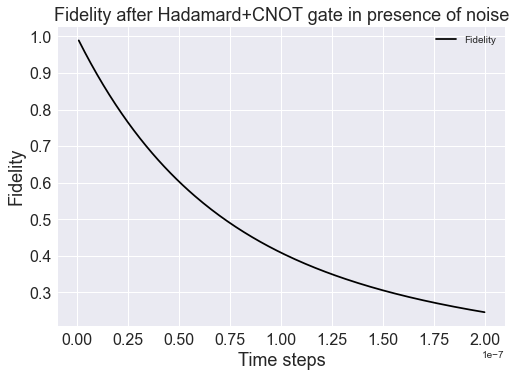

In [65]:
plt.style.use("seaborn")
plt.plot(t,F2,"black",label="Fidelity")
plt.ylabel("Fidelity", fontsize=18)
plt.xlabel("Time steps", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)   # helps to increase the size of the values in X and Y axis
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.title("Fidelity after Hadamard+CNOT gate in presence of noise", fontsize=18)
plt.legend()
plt.show()

In [60]:
cnot_0_2=np.array([[1,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,0,0,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,1,0,0,0],
                  [0,0,0,0,0,0,0,1],[0,0,0,0,0,0,1,0]])
cnot_0_2

tensor([[1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0]], requires_grad=True)

In [61]:
def Decoherent_state_3( t,  T1,  T2,  density_matrix):
    
    #rho=ρ_noise
    rho=density_matrix
    
    rho=np.dot(np.dot(cnot_0_2,rho),cnot_0_2) # applying 1st CNOT to qubits=[0,1]

    gamma,Lambda=ED(t,T1,T2)
    
    epsilon_AD_1=(2-gamma+2*np.sqrt(1-gamma-Lambda))/4*np.dot(I3,np.dot(rho,I3))+gamma*np.dot(X1,np.dot(rho,X1))/4+\
                 gamma*np.dot(Y1,np.dot(rho,Y1))/4+ (2-gamma-2*np.sqrt(1-gamma-Lambda))/4*np.dot(Z1,np.dot(rho,Z1))- \
                 gamma/4*np.dot(I3,np.dot(rho,Z1))-gamma/4*np.dot(Z1,np.dot(rho,I3))+(gamma/(4*1j))*np.dot(X1,np.dot(rho,Y1))-\
                 (gamma/(4*1j))*np.dot(Y1,np.dot(rho,X1))
    
    epsilon_AD_2=(2-gamma+2*np.sqrt(1-gamma-Lambda))/4*np.dot(I3,np.dot(epsilon_AD_1,I3))+gamma*np.dot(X2,np.dot(epsilon_AD_1,X2))/4+\
                 gamma*np.dot(Y2,np.dot(epsilon_AD_1,Y2))/4+ (2-gamma-2*np.sqrt(1-gamma-Lambda))/4*np.dot(Z2,np.dot(epsilon_AD_1,Z2))- \
                 gamma/4*np.dot(I3,np.dot(epsilon_AD_1,Z2))-gamma/4*np.dot(Z2,np.dot(epsilon_AD_1,I3))+(gamma/(4*1j))*np.dot(X2,np.dot(epsilon_AD_1,Y2))-\
                 (gamma/(4*1j))*np.dot(Y2,np.dot(epsilon_AD_1,X2))
    
    epsilon_AD_3=(2-gamma+2*np.sqrt(1-gamma-Lambda))/4*np.dot(I3,np.dot(epsilon_AD_2,I3))+gamma*np.dot(X3,np.dot(epsilon_AD_2,X3))/4+\
                 gamma*np.dot(Y3,np.dot(epsilon_AD_2,Y3))/4+ (2-gamma-2*np.sqrt(1-gamma-Lambda))/4*np.dot(Z3,np.dot(epsilon_AD_2,Z3))- \
                 gamma/4*np.dot(I3,np.dot(epsilon_AD_2,Z3))-gamma/4*np.dot(Z3,np.dot(epsilon_AD_2,I3))+(gamma/(4*1j))*np.dot(X3,np.dot(epsilon_AD_2,Y3))-\
                 (gamma/(4*1j))*np.dot(Y3,np.dot(epsilon_AD_2,X3))
    
    return epsilon_AD_3
    

In [33]:
ρ_noise3=[]
ρ_noise3=[Decoherent_state_3(time,T1,T2,density_matrix) for time,density_matrix in zip(t,ρ_noise2)] 
len(ρ_noise3)

200

In [34]:
rho2=density_matrix(3)  # this is the pure density matrix 
F3=[]
for rho1 in ρ_noise3:
    F3.append(Fidelity(rho1,rho2))
    

C:\Users\Arunava\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


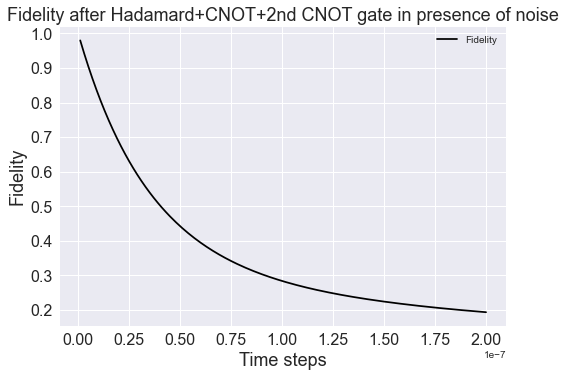

In [35]:
plt.style.use("seaborn")
plt.plot(t,F3,"black",label="Fidelity")
plt.ylabel("Fidelity", fontsize=18)
plt.xlabel("Time steps", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)   # helps to increase the size of the values in X and Y axis
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.title("Fidelity after Hadamard+CNOT+2nd CNOT gate in presence of noise", fontsize=18)
plt.legend()
plt.show()

In [36]:
H=1/np.sqrt(2)*np.array([[1,1],[1,-1]])

In [37]:
def Decoherent_state_4( t,  T1,  T2, density_matrix):
    
    #rho=ρ_noise
    rho=density_matrix
    
    rho=np.dot(np.dot(np.kron(np.kron(H,I),I),rho),np.transpose(np.conj(np.kron(np.kron(H,I),I))))
    
    gamma,Lambda=ED(t,T1,T2)
    
    epsilon_AD_1=(2-gamma+2*np.sqrt(1-gamma-Lambda))/4*np.dot(I3,np.dot(rho,I3))+gamma*np.dot(X1,np.dot(rho,X1))/4+\
                 gamma*np.dot(Y1,np.dot(rho,Y1))/4+ (2-gamma-2*np.sqrt(1-gamma-Lambda))/4*np.dot(Z1,np.dot(rho,Z1))- \
                 gamma/4*np.dot(I3,np.dot(rho,Z1))-gamma/4*np.dot(Z1,np.dot(rho,I3))+(gamma/(4*1j))*np.dot(X1,np.dot(rho,Y1))-\
                 (gamma/(4*1j))*np.dot(Y1,np.dot(rho,X1))
    
    epsilon_AD_2=(2-gamma+2*np.sqrt(1-gamma-Lambda))/4*np.dot(I3,np.dot(epsilon_AD_1,I3))+gamma*np.dot(X2,np.dot(epsilon_AD_1,X2))/4+\
                 gamma*np.dot(Y2,np.dot(epsilon_AD_1,Y2))/4+ (2-gamma-2*np.sqrt(1-gamma-Lambda))/4*np.dot(Z2,np.dot(epsilon_AD_1,Z2))- \
                 gamma/4*np.dot(I3,np.dot(epsilon_AD_1,Z2))-gamma/4*np.dot(Z2,np.dot(epsilon_AD_1,I3))+(gamma/(4*1j))*np.dot(X2,np.dot(epsilon_AD_1,Y2))-\
                 (gamma/(4*1j))*np.dot(Y2,np.dot(epsilon_AD_1,X2))
    
    epsilon_AD_3=(2-gamma+2*np.sqrt(1-gamma-Lambda))/4*np.dot(I3,np.dot(epsilon_AD_2,I3))+gamma*np.dot(X3,np.dot(epsilon_AD_2,X3))/4+\
                 gamma*np.dot(Y3,np.dot(epsilon_AD_2,Y3))/4+ (2-gamma-2*np.sqrt(1-gamma-Lambda))/4*np.dot(Z3,np.dot(epsilon_AD_2,Z3))- \
                 gamma/4*np.dot(I3,np.dot(epsilon_AD_2,Z3))-gamma/4*np.dot(Z3,np.dot(epsilon_AD_2,I3))+(gamma/(4*1j))*np.dot(X3,np.dot(epsilon_AD_2,Y3))-\
                 (gamma/(4*1j))*np.dot(Y3,np.dot(epsilon_AD_2,X3))
    
    return epsilon_AD_3
    

In [38]:
ρ_noise4=[]
ρ_noise4=[Decoherent_state_4(time,T1,T2,density_matrix) for time,density_matrix in zip(t,ρ_noise3)] 
len(ρ_noise4)

200

In [39]:
rho2=density_matrix(4)  # this is the pure density matrix 
F4=[]
for rho1 in ρ_noise4:
    F4.append(Fidelity(rho1,rho2))
    

C:\Users\Arunava\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


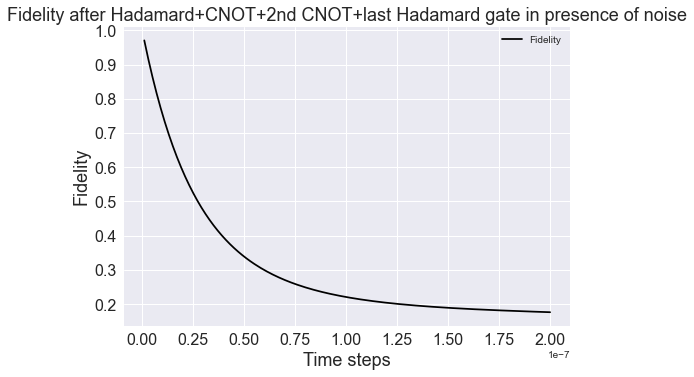

In [40]:
plt.style.use("seaborn")
plt.plot(t,F4,"black",label="Fidelity")
plt.ylabel("Fidelity", fontsize=18)
plt.xlabel("Time steps", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)   # helps to increase the size of the values in X and Y axis
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.title("Fidelity after Hadamard+CNOT+2nd CNOT+last Hadamard gate in presence of noise", fontsize=18)
plt.legend()
plt.show()

In [41]:
from qiskit import QuantumCircuit
import qiskit.quantum_info as qi

In [42]:
for index,fidelity in enumerate(F4):
    if fidelity>0.545 and fidelity<0.555:
        print(index,"->",fidelity)

22 -> (0.5479242262026187+0j)


In [43]:
Fidelity(ρ_noise4[22],density_matrix(4))

(0.5479242262026187+0j)

In [45]:
rho_test=ρ_noise4[22]

In [46]:
rho_1 = qi.partial_trace(rho_test,[1,2])

In [47]:
rho_1

DensityMatrix([[0.40408404+0.j, 0.        +0.j],
               [0.        +0.j, 0.57741232+0.j]],
              dims=(2,))


In [39]:
rho_test

tensor([[ 0.28672654+0.j,  0.        +0.j,  0.        +0.j,
          0.09014874+0.j,  0.2334093 +0.j,  0.        +0.j,
          0.        +0.j, -0.08489888+0.j],
        [ 0.        +0.j,  0.03428181+0.j,  0.        +0.j,
          0.        +0.j,  0.        +0.j, -0.02538557+0.j,
          0.        +0.j,  0.        +0.j],
        [ 0.        +0.j,  0.        +0.j,  0.03428181+0.j,
          0.        +0.j,  0.        +0.j,  0.        +0.j,
         -0.00625386+0.j,  0.        +0.j],
        [ 0.09014874+0.j,  0.        +0.j,  0.        +0.j,
          0.17382756+0.j,  0.08489888+0.j,  0.        +0.j,
          0.        +0.j, -0.12871875+0.j],
        [ 0.2334093 +0.j,  0.        +0.j,  0.        +0.j,
          0.08489888+0.j,  0.255169  +0.j,  0.        +0.j,
          0.        +0.j, -0.09014874+0.j],
        [ 0.        +0.j, -0.02538557+0.j,  0.        +0.j,
          0.        +0.j,  0.        +0.j,  0.03050871+0.j,
          0.        +0.j,  0.        +0.j],
        [ 0.    